In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
import pyreadr
import requests
import urllib.request
import math
import pandas as pd 
import random
import numpy as np
from sklearn.datasets import load_iris 
from scipy.ndimage import gaussian_filter
from sklearn import preprocessing
from sklearn import utils

    
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import svm
from torchvision import datasets, transforms
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Plant 1 datasets
P1G=pd.read_csv('Plant_1_Generation_Data.csv',na_values= '?')
P1W=pd.read_csv('Plant_1_Weather_Sensor_Data.csv',na_values= '?')

#Plant 2 datasets
P2G=pd.read_csv('Plant_2_Generation_Data.csv',na_values= '?')
P2W=pd.read_csv('Plant_2_Weather_Sensor_Data.csv',na_values= '?')


display(P2W)
display(P2G)

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0
...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,4136001,iq8k7ZNt4Mwm3w0,23.291048,22.373909,0.0


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07
...,...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08


3158

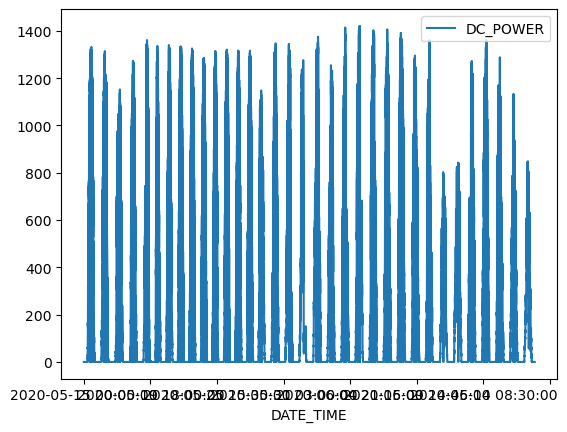

In [3]:
P2G.plot(x="DATE_TIME",y="DC_POWER")
len(P1G['DATE_TIME'].unique())

In [4]:
#Copying generation and weather data from plant 1
generation_data=P2G.copy()
weather_data=P2W.copy()



#Converting the DATE_TIME to a pandas datetime object
generation_data['DATE_TIME'] = pd.to_datetime(generation_data["DATE_TIME"])
weather_data['DATE_TIME'] = pd.to_datetime(weather_data["DATE_TIME"])

generation_data.drop(['SOURCE_KEY','PLANT_ID','TOTAL_YIELD'],axis=1,inplace=True) # Dropping irrellevant columns
generation_summed=(generation_data.groupby("DATE_TIME", sort=False).sum()).reset_index() # Summing production for all inverters

weather_data.drop(['PLANT_ID','SOURCE_KEY'],axis=1,inplace=True)# Dropping irrellevant columns

df=pd.merge(generation_summed,weather_data, on='DATE_TIME')
#df.drop(['DC_POWER','DAILY_YIELD'],axis=1,inplace=True)
#display(df)
#df.to_csv(df.to_csv('Plant2_full_dataset.csv', sep=',')) #Saving CSV of full Plant 2 dataset
#df.to_csv(df.to_csv('Plant2_summed_dataset.csv', sep=','))

In [5]:
#P2G.isna().sum()
display(weather_data)
display(generation_summed)
display(df)
print(len(weather_data['DATE_TIME'].unique()))

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,26.596148,25.088210,0.0
...,...,...,...,...
3254,2020-06-17 22:45:00,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,23.291048,22.373909,0.0


,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD
0,2020-05-15 00:00:00,0.0,0.0,48899.938095
1,2020-05-15 00:15:00,0.0,0.0,28401.000000
2,2020-05-15 00:30:00,0.0,0.0,28401.000000
3,2020-05-15 00:45:00,0.0,0.0,28401.000000
4,2020-05-15 01:00:00,0.0,0.0,26516.000000
...,...,...,...,...
3254,2020-06-17 22:45:00,0.0,0.0,93040.000000
3255,2020-06-17 23:00:00,0.0,0.0,93040.000000
3256,2020-06-17 23:15:00,0.0,0.0,93040.000000
3257,2020-06-17 23:30:00,0.0,0.0,93040.000000


,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,48899.938095,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,0.0,0.0,28401.000000,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,0.0,0.0,28401.000000,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,0.0,0.0,28401.000000,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,0.0,0.0,26516.000000,26.596148,25.088210,0.0
...,...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,0.0,0.0,93040.000000,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,0.0,0.0,93040.000000,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,0.0,0.0,93040.000000,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,0.0,0.0,93040.000000,23.291048,22.373909,0.0


3259


In [6]:
X=df.drop(['DATE_TIME','DC_POWER','DAILY_YIELD','AC_POWER'],axis=1)
y=df['AC_POWER']
display(X)
display(y)

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,27.004764,25.060789,0.0
1,26.880811,24.421869,0.0
2,26.682055,24.427290,0.0
3,26.500589,24.420678,0.0
4,26.596148,25.088210,0.0
...,...,...,...
3254,23.511703,22.856201,0.0
3255,23.482282,22.744190,0.0
3256,23.354743,22.492245,0.0
3257,23.291048,22.373909,0.0


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3254    0.0
3255    0.0
3256    0.0
3257    0.0
3258    0.0
Name: AC_POWER, Length: 3259, dtype: float64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=6/34, shuffle=False)
tss=TimeSeriesSplit(n_splits=4)

for i, (train_index, test_index) in enumerate(tss.split(X_train)):
    if i==0:
        fold1_train=np.asarray(train_index).astype(int)
        fold1_test=np.asarray(test_index).astype(int)
    elif i==1:
        fold2_train=np.asarray(train_index).astype(int)
        fold2_test=np.asarray(test_index).astype(int)
    elif i==2:
        fold3_train=np.asarray(train_index).astype(int)
        fold3_test=np.asarray(test_index).astype(int)
    elif i==3:
        fold4_train=np.asarray(train_index).astype(int)
        fold4_test=np.asarray(test_index).astype(int)
print(np.shape(X_train))

(2683, 3)


In [35]:
scaler=StandardScaler()
scaler.fit(X)

X_test=pd.DataFrame(scaler.transform(X_test))
X_train=pd.DataFrame(scaler.transform(X_train))


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [46]:
knn=neighbors.KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train.iloc[fold1_train,:],y_train.iloc[fold1_train])
fold1_prediction=knn.predict(X_train.iloc[fold1_test,:])

knn.fit(X_train.iloc[fold2_train,:],y_train.iloc[fold2_train])
fold2_prediction=knn.predict(X_train.iloc[fold2_test,:])

knn.fit(X_train.iloc[fold3_train,:],y_train.iloc[fold3_train])
fold3_prediction=knn.predict(X_train.iloc[fold3_test,:])

knn.fit(X_train.iloc[fold4_train,:],y_train.iloc[fold4_train])
fold4_prediction=knn.predict(X_train.iloc[fold4_test,:])




array([1.31157324e+04, 1.48223021e+04, 1.11858588e+04, 1.35025348e+04,
       1.38060782e+04, 1.42165050e+04, 1.47056440e+04, 1.50295554e+04,
       1.56816685e+04, 1.37663728e+04, 1.44047556e+04, 1.38443005e+04,
       1.59798435e+04, 1.56100233e+04, 1.19124585e+04, 1.51003860e+04,
       1.55564857e+04, 1.62467769e+04, 1.60203302e+04, 1.58557597e+04,
       1.60024453e+04, 1.35993175e+04, 1.02666235e+04, 1.06522270e+04,
       1.02746513e+04, 9.84766464e+03, 1.01595200e+04, 8.26909674e+03,
       6.48565802e+03, 4.67606898e+03, 3.19368086e+03, 1.68139905e+03,
       9.77857952e+02, 7.19915714e+01, 3.44199286e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24000000e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.02790000e+01,
       1.40607381e+01, 1.21694762e+01, 2.62302143e+01, 1.21694762e+01,
       1.21694762e+01, 1.18579643e+02, 3.01889524e+01, 1.80072619e+01,
      

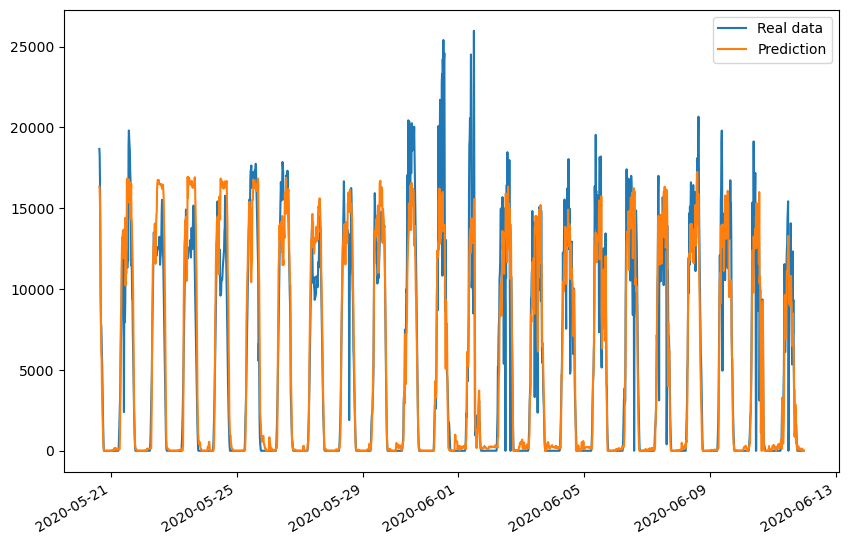

In [59]:
Dates=df.iloc[fold1_test[0]:2683,:]['DATE_TIME']
predictions=np.concatenate((fold1_prediction,fold2_prediction,fold3_prediction,fold4_prediction))

plt.figure(figsize=(10,6))
plt.plot(Dates, y_train.iloc[fold1_test[0]:2683])
plt.plot(Dates, predictions)

plt.xticks(rotation=30, ha='right')
plt.legend(['Real data','Prediction'])

i:2
i:3
i:4
i:5
i:6
i:7
i:8
i:9
i:10
i:11
i:12
i:13
i:14
i:15
i:16
i:17
i:18
i:19
i:20
i:21
i:22
i:23
i:24
i:25
i:26
i:27
i:28
i:29
i:30
i:31
i:32
i:33
i:34
i:35
i:36
i:37
i:38
i:39
i:40
i:41
i:42
i:43
i:44
i:45
i:46
i:47
i:48
i:49
i:50
i:51
i:52
i:53
i:54
i:55
i:56
i:57
i:58
i:59
i:60
i:61
i:62
i:63
i:64
i:65
i:66
i:67
i:68
i:69
i:70
i:71
i:72
i:73
i:74
i:75
i:76
i:77
i:78
i:79
i:80
i:81
i:82
i:83
i:84
i:85
i:86
i:87
i:88
i:89
i:90
i:91
i:92
i:93
i:94
i:95
i:96
i:97
i:98
i:99
i:100
standard deviation:
[0.07673896 0.07110705 0.06794401 0.06637315 0.06456755 0.06112288
 0.06193739 0.05989088 0.05840102 0.05692569 0.05545247 0.05471129
 0.0553041  0.05415605 0.05374543 0.05448542 0.05533489 0.05513584
 0.05446771 0.05539515 0.05592269 0.05547196 0.05553456 0.05537643
 0.05541791 0.05541935 0.05480558 0.05483244 0.05472741 0.05493774
 0.05527214 0.05516165 0.0556242  0.0553805  0.05508935 0.05541876
 0.05561648 0.05505853 0.05503527 0.05486627 0.05482429 0.05461633
 0.05440665 0.0544883  

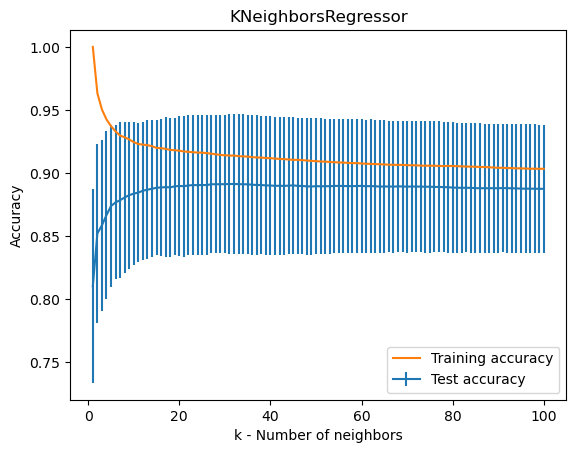

In [13]:
#Loop settings
neighb=100
k_folds=10


#knn = KNeighborsClassifier(n_neighbors=1)
knn = neighbors.KNeighborsRegressor(n_neighbors=1)
cv_scores=cross_val_score(knn, X_train, y_train, cv=k_folds)

for i in range(2,neighb+1):
    #knn = KNeighborsClassifier(n_neighbors=i)
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    #train model with cv of 5 
    cv_scores = np.append(cv_scores,cross_val_score(knn, X_train, y_train, cv=k_folds))
    print('i:{}'.format(i))

scores = np.reshape(cv_scores,(neighb,k_folds))
StanDev = np.zeros(neighb)
RowMeans= np.zeros(neighb)
for i in range(neighb):
    StanDev[i]=statistics.stdev(scores[i])
    RowMeans[i]=np.mean(scores[i])
    #print(scores[i])
print("standard deviation:\n{}".format(StanDev))
print("Means for k=1:10:\n {}".format(RowMeans))


#knn_train = KNeighborsClassifier(n_neighbors=1)
knn_train = neighbors.KNeighborsRegressor(n_neighbors=1)
knn_train.fit(X_train,y_train)
train_scores=knn_train.score(X_train,y_train)

for i in range(2,neighb+1):
    #knn_train = KNeighborsClassifier(n_neighbors=i)
    knn_train = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn_train.fit(X_train,y_train)
    train_scores=np.append(train_scores,knn_train.score(X_train,y_train))
    
ks=np.arange(1,neighb+1)
print(np.shape(ks))
print(train_scores)
print(np.where(RowMeans==max(RowMeans)))
print("Unique labels",len(np.unique(y_train)))
print("Number of labels",len(y_train))
plt.errorbar(ks, RowMeans,yerr=StanDev)
plt.plot(ks,train_scores)
plt.xlabel('k - Number of neighbors')
plt.legend(['Training accuracy','Test accuracy'],loc=4)
plt.title('KNeighborsRegressor')
plt.ylabel('Accuracy')
#plt.axis([0, neighbors, 0.4, 0.6])
plt.show()